In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import datetime
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('conversations_with_sentimpact.csv', encoding='ISO-8859-1')

C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
df.head(5)

,Unnamed: 0,Unnamed: 0.1,False,conversation_id,raw_tweets_info,conversation_length,tweet_ids,user_ids,airlines_involved,mean_sentiment,sentiments,full_text,dates,SentChange
0,0,0,0,5,"[(747530773037780992, 31132554), (747526794446...",2,"[747526794446802944, 747530773037780992]","[22873368, 31132554]",['No airlines involved'],NaN,"[nan, 1]",['Hey @British_Airways our @easyJet flight Ven...,"['Mon Jun 27 20:27:30 +0000 2016', 'Mon Jun 27...",[]
1,1,1,1,6,"[(747530681509625860, 417945325), (74745123859...",2,"[747451238598475776, 747530681509625860]","[55904765, 417945325]",['No airlines involved'],0.0,"[0, 0]",['@easyJet thanks for looking after my luggage...,"['Mon Jun 27 15:27:16 +0000 2016', 'Mon Jun 27...",[]
2,2,2,2,11,"[(747530531475173376, 597673831), (74752831114...",2,"[747528311144734720, 747530531475173376]","[427951650, 597673831]",['No airlines involved'],0.5,"[1, 0]","[""@British_Airways I booked via Expedia. I'm n...","['Mon Jun 27 20:33:32 +0000 2016', 'Mon Jun 27...",[]
3,3,3,3,12,"[(747530509098450944, 1624311463), (7475297117...",2,"[747529711782244352, 747530509098450944]","[1624311463, 1624311463]",['No airlines involved'],0.0,"[0, 0]",['@easyJet is there anyway to travel with 2 ca...,"['Mon Jun 27 20:39:06 +0000 2016', 'Mon Jun 27...",[]
4,4,4,4,14,"[(747530348561571840, 154605692), (74752081839...",2,"[747520818398232576, 747530348561571840]","[117754884, 154605692]",['No airlines involved'],0.5,"[1, 0]",['@easyJet how nice of you not to reply to my ...,"['Mon Jun 27 20:03:46 +0000 2016', 'Mon Jun 27...",[]


In [4]:
#helper functions
def append_row(df, entry):
    assert len(df.columns) == len(entry), "Not enough data"
    df2 = pd.DataFrame([entry,], columns=df.columns)
    return df.append(df2, ignore_index=True)

def time_delta(datestring1, datestring2):
    date1 = datetime.datetime.strptime(datestring1, '%a %b %d %H:%M:%S +0000 %Y')
    date2 = datetime.datetime.strptime(datestring2, '%a %b %d %H:%M:%S +0000 %Y')
    if date2 > date1:
        timedelta = date2 - date1
        return(timedelta.seconds)
    else:
        return("err")
    

In [5]:
def sentiment_vs_replytime(airline, airline_id, df):
    total = 0
    errors = 0
    
    #filter on specific airline
    if len(airline) == 1:
        df_airline = df[df['airlines_involved'] == f"['{airline[0]}']"]
        print(f"[{airline[0]}]")
        print(df_airline.shape)
    else:
        df_airline = df
    
    df_interaction = pd.DataFrame(columns=['replyTime'])
    #find interactions
    for data in df_airline[['user_ids', 'dates']].values:
        all_ids = eval(data[0])
        for i in range(0, len(all_ids)):
            if (str(all_ids[i]) in airline_id) and (i!=0):   
                try:
                    total += 1
                    date1 = eval(data[1])[i-1]
                    date2 = eval(data[1])[i]
                    replytime = time_delta(date1, date2)
                    if replytime != 'err':
                        df_interaction = append_row(df_interaction, [replytime,])
                    else:
                        pass
                except NameError:
                    errors += 1
                    pass
    
    print('errors: ' + str(errors))
    print('total: ' + str(total))
    return df_interaction

In [6]:
df_klm1 = sentiment_vs_replytime(["KLM"],["56377143"], df)
df_klm1['replyTime'] = df_klm1['replyTime'].astype('int64')

[KLM]
(37868, 14)
errors: 28
total: 36128


In [7]:
df_ba1 = sentiment_vs_replytime(["British_Airways"],["18332190"], df)
df_ba1['replyTime'] = df_ba1['replyTime'].astype('int64')

[British_Airways]
(68941, 14)
errors: 3
total: 61654


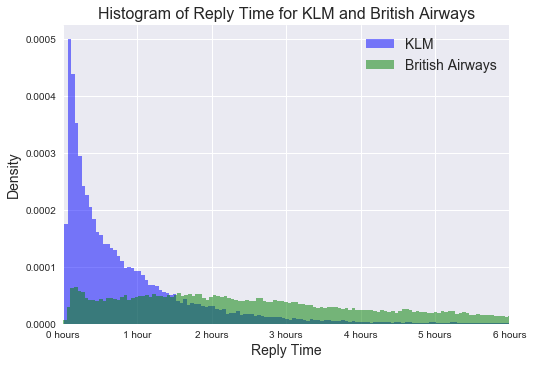

In [9]:
fig, ax = plt.subplots(nrows=1, ncols=1)
#plt.hist([df_ba1['replyTime'],df_klm1['replyTime']], color = ['b','g'],label=['BA','KLM'])
plt.hist(df_klm1['replyTime'], normed=True, color ='b', alpha=0.5, bins=500, label="KLM")
plt.hist(df_ba1['replyTime'], normed=True, color ='g', alpha=0.5, bins=500, label="British Airways")
plt.xlim(0, 21600)
plt.legend(prop={'size': 14})
plt.xticks([0, 3600, 7200, 10800, 14400, 18000, 21600], ['0 hours', '1 hour', '2 hours', '3 hours', '4 hours', '5 hours', '6 hours'])
#plt.yticks([0, 500, 1000, 1500, 2000, 2500, 3000], ['0', '0.05', '0.10', '0.15', '0.20', '0.25', '0.30'])

plt.title('Histogram of Reply Time for KLM and British Airways', size=16)
plt.ylabel('Density', size=14)
plt.grid(True)
plt.xlabel('Reply Time', size=14)
plt.savefig("Histogram_replytime_klm_ba.svg", dpi=300)
plt.show()

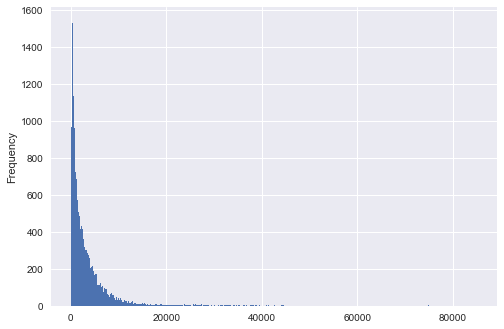

In [13]:
df_klm1['replyTime'].plot(kind='hist', bins=1000)
#plt.xlim(0, 3600)
plt.show()

In [15]:
print(df_klm1['replyTime'].mean())
print(df_klm1[df_klm1['replyTime'] < 3600].shape[0]/ df_klm1.shape[0])

3625.4993905817173
0.6946814404432133


In [19]:
print(df_ba1['replyTime'].mean()//60, df_ba1['replyTime'].mean()%60)
print(df_ba1[df_ba1['replyTime'] < 3600].shape[0]/ df_ba1.shape[0])

279.0 52.156396489917825
0.16011094710548085
